In [1]:
from utils import assign_free_gpus
assign_free_gpus()

import time
import json
from pathlib import Path
from sklearn.datasets import make_moons
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn.functional as F
import pytorch_lightning as pl

from generate_data import MoonsDataModule, MoonsDataset
from models import LinearClassifier, Classifier, GAN

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)
path_results = Path.cwd().parent.parent / 'results' / 'moons'

Using GPU(s): 0


/tmp/ipykernel_843050/2503995172.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/gpfslocalsup/pub/anaconda-py3/2022.05/envs/pytorch-gpu-1.13.0+py3.10.8/lib/python3.10/site-packages/nvidia/dali/backend.py:46: Warning: DALI support for Python 3.10 is experimental and some functionalities may not work.
  deprecation_warning("DALI support for Python 3.10 is experimental and some functionalities "


In [7]:
import torch

torch.max(torch.ones((5, 2)), dim=1, keepdims=True).values

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [5]:
torch.ones((5, 2))

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [3]:
noise = 0.3
linear = False
path_classifier = path_results / 'classifier' / '2023-05-24_095926_noise0.3' / 'checkpoints' / 'epoch=99-step=6300.ckpt'
path_gan = path_results / 'GAN' / '2023-05-24_103512_noise0.3_classCondone-hot_classifCondMSP' / 'checkpoints' / 'epoch=99-step=12600.ckpt'
# path_gan = path_results / 'GAN' / '2023-06-08_162712_noise0.3_classCondone-hot_classifCondMSP' / 'checkpoints' / 'epoch=499-step=63000.ckpt'
classifier = Classifier.load_from_checkpoint(str(path_classifier))

# noise = 0.3
# linear = True
# path_classifier = path_results / 'classifier' / '2023-05-24_100150_noise0.3_linear' / 'checkpoints' / 'epoch=99-step=6300.ckpt'
# path_gan = path_results / 'GAN' / '2023-05-24_103603_noise0.3_classCondone-hot_classifCondMSP_linear' / 'checkpoints' / 'epoch=99-step=12600.ckpt'
# classifier = LinearClassifier.load_from_checkpoint(str(path_classifier))

gan = GAN.load_from_checkpoint(str(path_gan), classifier=classifier)

In [4]:
data_test = MoonsDataset(n_samples=5000, noise=noise, random_state=2)
x_test = data_test.x
y_test = data_test.y

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.921750009059906     │
│         val_loss          │    0.20323796570301056    │
└───────────────────────────┴───────────────────────────┘

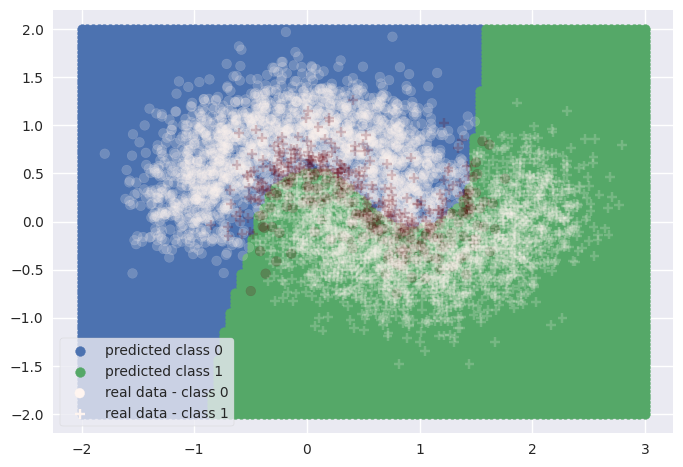

In [5]:
trainer = pl.Trainer(accelerator='auto', devices=1)
trainer.validate(classifier, datamodule=MoonsDataModule(n_samples=20000, noise=noise, random_state=2))

# SHOW DESCISION BOUNDARY
x = np.linspace(-2, 3, 100)
y = np.linspace(-2, 2, 100)

grid_data = np.zeros((len(x)*len(y), 2))
i = 0
for x_ in x:
    for y_ in y:
        grid_data[i] = [x_, y_]
        i += 1
grid_data = torch.from_numpy(grid_data).float()

with torch.no_grad():
    y = classifier(grid_data)
class_pred_grid = torch.sigmoid(y).round().cpu().flatten()#.numpy()

# SHOW CLASSIF LOSS
with torch.no_grad():
    logits = classifier(x_test)
    classif_loss = F.binary_cross_entropy_with_logits(logits.squeeze(), y_test, reduction='none')
    
# CORRECT PRED
class_pred = torch.sigmoid(logits).round().cpu().flatten()
classif_loss = class_pred != y_test

fig, ax = plt.subplots()
# ax.set_title('classifier decision boundary')
ax.scatter(grid_data[class_pred_grid==0, 0], grid_data[class_pred_grid==0, 1], alpha=1, c='C0', label='predicted class 0')
ax.scatter(grid_data[class_pred_grid!=0, 0], grid_data[class_pred_grid!=0, 1], alpha=1, c='C1', label='predicted class 1')
ax.scatter(x_test[y_test==0, 0], x_test[y_test==0, 1], alpha=0.2, c=classif_loss[y_test==0], cmap='Reds', marker='o', label='real data - class 0')
im = ax.scatter(x_test[y_test==1, 0], x_test[y_test==1, 1], alpha=0.2, c=classif_loss[y_test==1], cmap='Reds', marker='+', label='real data - class 1')
leg = ax.legend(frameon=True)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# cbar = fig.colorbar(im, ax=ax, label='prediction error')
# cbar.solids.set(alpha=1)

plt.savefig('results_moons_classifier')

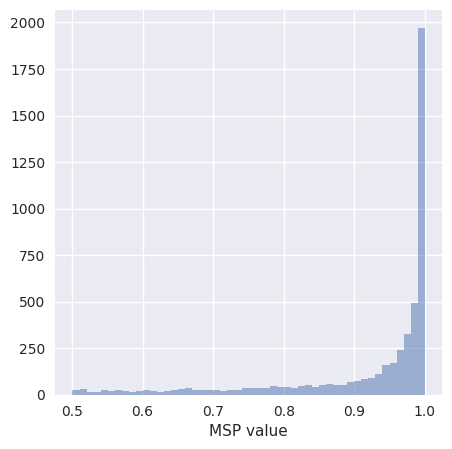

In [6]:
def get_MSP(dataloader, classifier, device):

    classifier.eval()
    msp = torch.zeros((len(dataloader.dataset)))
    # tcp = torch.zeros((len(dataloader.dataset)))
    idx = 0
    for X, y in dataloader:
        batch_size = X.shape[0]

        with torch.no_grad():
            logits = classifier(X)
        probas_class1 = torch.sigmoid(logits).squeeze()
        probas_class0 = 1 - probas_class1
        msp[idx:idx+batch_size] = torch.maximum(probas_class0, probas_class1)
        idx += batch_size

    return msp

msp_test = get_MSP(DataLoader(data_test, 1000), classifier, device)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel('MSP value')
ax.hist(msp_test, alpha=0.5, bins=50, log=False)

plt.savefig('results_moons_classifier_MSP')

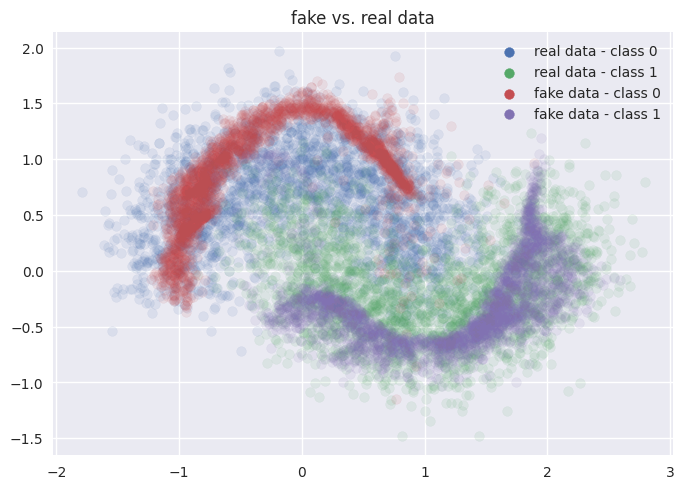

In [7]:
n_samples = len(x_test)
z = torch.randn(n_samples, gan.latent_dim, device=gan.device)
# if gan.condition_dim > 0:
rnd_label = torch.randint(2, size=(z.shape[0],), device=gan.device)
c = F.one_hot(rnd_label, num_classes=2)
confidence = 0.999*torch.ones((n_samples, 1), device=gan.device)
# confidence = torch.rand((n_samples, 1), device=gan.device)
z = torch.cat([z, c, confidence], dim=1)
with torch.no_grad():
    w = gan.generator.mapping(z)
    x_fake = gan.generator.synthesis(w).detach().cpu().numpy()
    rnd_label = rnd_label.cpu().numpy()
    w = w.detach().cpu().numpy()

plt.figure()
plt.title('fake vs. real data')
plt.scatter(x_test[y_test==0, 0], x_test[y_test==0, 1], alpha=0.1, c='C0', label='real data - class 0')
plt.scatter(x_test[y_test==1, 0], x_test[y_test==1, 1], alpha=0.1, c='C1', label='real data - class 1')
plt.scatter(x_fake[rnd_label==0, 0], x_fake[rnd_label==0, 1], alpha=0.1, c='C2', label='fake data - class 0')
plt.scatter(x_fake[rnd_label==1, 0], x_fake[rnd_label==1, 1], alpha=0.1, c='C3', label='fake data - class 1')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# w_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(w)
# plt.figure()
# plt.title('t-SNE in W')
# plt.scatter(w_embedded[rnd_label==0, 0], w_embedded[rnd_label==0, 1], alpha=0.5, c='C0', label='class 0')
# plt.scatter(w_embedded[rnd_label==1, 0], w_embedded[rnd_label==1, 1], alpha=0.5, c='C1', label='class 1')
# plt.legend()

/tmp/ipykernel_843050/3829486005.py:23: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


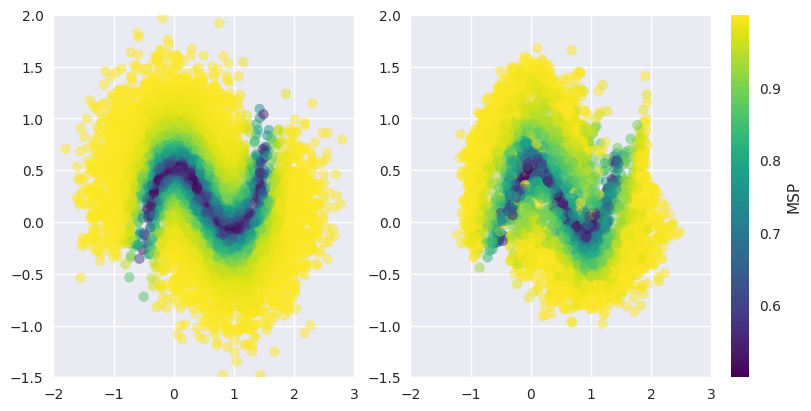

In [8]:
# Generate fake data conditioned by class and msp
n_samples = len(x_test)
z = torch.randn(n_samples, gan.latent_dim, device=gan.device)
if gan.condition_dim > 0:
    rnd_label = torch.randint(2, size=(z.shape[0],), device=gan.device)
    c = F.one_hot(rnd_label, num_classes=2)
    # confidence = 0.2*torch.ones((n_samples, 1), device=gan.device)
    # confidence = torch.rand((n_samples, 1), device=gan.device)
    confidence = msp_test[torch.randperm(msp_test.shape[0])].unsqueeze(1)
    z = torch.cat([z, c, confidence], dim=1)
with torch.no_grad():
    w = gan.generator.mapping(z)
    x_fake = gan.generator.synthesis(w).detach().cpu().numpy()

# confidence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
# ax1.set_title('MSP computed from real data')
# ax2.set_title('generated data conditioned by MSP')
scat1 = ax1.scatter(x_test[:, 0].cpu().numpy(), x_test[:, 1].cpu().numpy(), c=msp_test.cpu().numpy(), cmap='viridis', alpha=0.5)
scat2 = ax2.scatter(x_fake[:, 0], x_fake[:, 1], c=confidence.cpu().numpy(), cmap='viridis', alpha=0.5)
cb = fig.colorbar(scat2, ax=ax2, label='MSP')
cb.set_alpha(1)
cb.draw_all()
for ax in [ax1, ax2]:
    ax.set_xlim([-2, 3])
    ax.set_ylim([-1.5, 2])
    
plt.savefig('results_moons_generator')

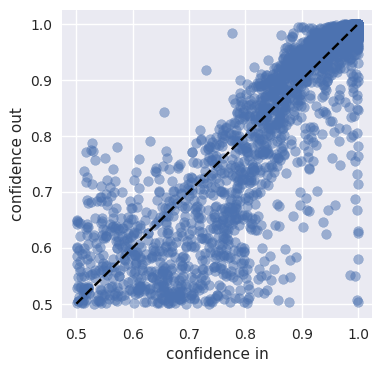

In [12]:
with torch.no_grad():
    logits = classifier(torch.from_numpy(x_fake))
    probas_class1 = torch.sigmoid(logits).squeeze()
    probas_class0 = 1 - probas_class1
    confidence_out = torch.maximum(probas_class0, probas_class1)
    

plt.figure(figsize=(4,4))
plt.scatter(confidence.cpu(), confidence_out.cpu(), alpha=0.5)
plt.plot([0.5, 1], [0.5, 1], c='k', ls='--')
plt.xlabel('confidence in')
plt.ylabel('confidence out')

plt.savefig('results_moons_generator_MSP')